In [40]:
# Cell 1: Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [41]:
# Cell 2: Load the data
# Assuming the data is already loaded
df = pd.read_csv("1.csv")


In [42]:
# Cell 3: Feature engineering - Add year and week of the year columns
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['week_of_year'] = df['transaction_date'].dt.isocalendar().week
df['year'] = df['transaction_date'].dt.year


In [43]:
# Cell 4: Function to aggregate sales data weekly
def aggregate_weekly_sales(df_product):
    weekly_sales = df_product.groupby(['year', 'week_of_year']).agg({'quantity': 'sum'}).reset_index()
    weekly_sales['date'] = pd.to_datetime(weekly_sales['year'].astype(str) + '-' + weekly_sales['week_of_year'].astype(str) + '-1', format='%Y-%W-%w')
    weekly_sales.set_index('date', inplace=True)
    
    # Exogenous variables: Here, we'll just use 'discount_applied' and 'product_stock' as features for simplicity.
    exogenous = df_product.groupby(['year', 'week_of_year']).agg({'discount_applied': 'mean', 'product_stock': 'mean'}).reset_index()
    exogenous['date'] = pd.to_datetime(exogenous['year'].astype(str) + '-' + exogenous['week_of_year'].astype(str) + '-1', format='%Y-%W-%w')
    exogenous.set_index('date', inplace=True)
    
    return weekly_sales['quantity'], exogenous[['discount_applied', 'product_stock']]


In [44]:
# Cell 5: Feature engineering and preprocessing
def feature_engineering_and_preprocessing(df_product):
    df_product['week_of_year'] = df_product['transaction_date'].dt.isocalendar().week
    df_product['year'] = df_product['transaction_date'].dt.year
    return df_product


In [45]:
import pickle
from statsmodels.tsa.statespace.sarimax import SARIMAX

def train_and_save_sarimax_model(df, product_id, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52), save_model_filename=None):
    # Filter the data for the specific product_id
    df_product = df[df['product_id'] == product_id]

    if df_product.empty:
        raise ValueError(f"No data found for product ID {product_id}")

    # Feature engineering and preprocessing
    df_product = feature_engineering_and_preprocessing(df_product)

    # Aggregate the sales data to weekly sales
    weekly_sales, exogenous_weekly = aggregate_weekly_sales(df_product)

    # Check if we have data to train the model
    if len(weekly_sales) == 0 or len(exogenous_weekly) == 0:
        raise ValueError(f"No valid sales or exogenous data available for product ID {product_id}")

    # Train the SARIMAX model
    model = SARIMAX(weekly_sales, exog=exogenous_weekly, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()

    # Save the model to a file (pickle)
    if save_model_filename:
        with open(save_model_filename, 'wb') as f:
            pickle.dump(model_fit, f)
        print(f"Model for Product ID {product_id} saved to {save_model_filename}")
    
    return model_fit


In [46]:
import matplotlib.pyplot as plt
import pandas as pd

# Function to plot the forecast
def plot_sales_forecast(model_fit, df, product_id, forecast_steps=12):
    df_product = df[df['product_id'] == product_id]
    df_product = feature_engineering_and_preprocessing(df_product)

    # Aggregate the sales data to weekly sales
    weekly_sales, exogenous_weekly = aggregate_weekly_sales(df_product)

    # Forecasting the next 12 weeks
    forecast = model_fit.forecast(steps=forecast_steps, exog=exogenous_weekly[-forecast_steps:])

    # Plotting the historical sales and the forecasted sales
    plt.figure(figsize=(10, 6))
    
    # Plot historical sales
    plt.plot(weekly_sales.index, weekly_sales, label='Historical Sales', marker='o')
    
    # Generate the forecasted dates
    forecast_dates = pd.date_range(weekly_sales.index[-1], periods=forecast_steps + 1, freq='W')[1:]
    
    # Plot forecasted sales
    plt.plot(forecast_dates, forecast, color='red', label='Forecasted Sales', marker='x')
    
    # Add titles and labels
    plt.title(f'Sales Forecast for Product ID {product_id} - Next {forecast_steps} Weeks')
    plt.xlabel('Date')
    plt.ylabel('Quantity Sold')
    plt.legend()
    plt.grid()
    plt.show()

    return forecast


In [47]:
# Example usage
save_model_filename = 'sarimax_model_product_4175.pkl'  # Specify the file name for saving the model

# Train and save the model for a specific product
model_fit = train_and_save_sarimax_model(df, product_id=4175, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52), save_model_filename=save_model_filename)


/var/folders/q2/mr2wxd253jl7621ph74vbnwr0000gn/T/ipykernel_51573/4155495590.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_product['week_of_year'] = df_product['transaction_date'].dt.isocalendar().week
/var/folders/q2/mr2wxd253jl7621ph74vbnwr0000gn/T/ipykernel_51573/4155495590.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_product['year'] = df_product['transaction_date'].dt.year
/Users/shivanshmahajan/Desktop/slaes/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: Value

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


Model for Product ID 4175 saved to sarimax_model_product_4175.pkl


/var/folders/q2/mr2wxd253jl7621ph74vbnwr0000gn/T/ipykernel_51573/4155495590.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_product['week_of_year'] = df_product['transaction_date'].dt.isocalendar().week
/var/folders/q2/mr2wxd253jl7621ph74vbnwr0000gn/T/ipykernel_51573/4155495590.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_product['year'] = df_product['transaction_date'].dt.year
/Users/shivanshmahajan/Desktop/slaes/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: Value

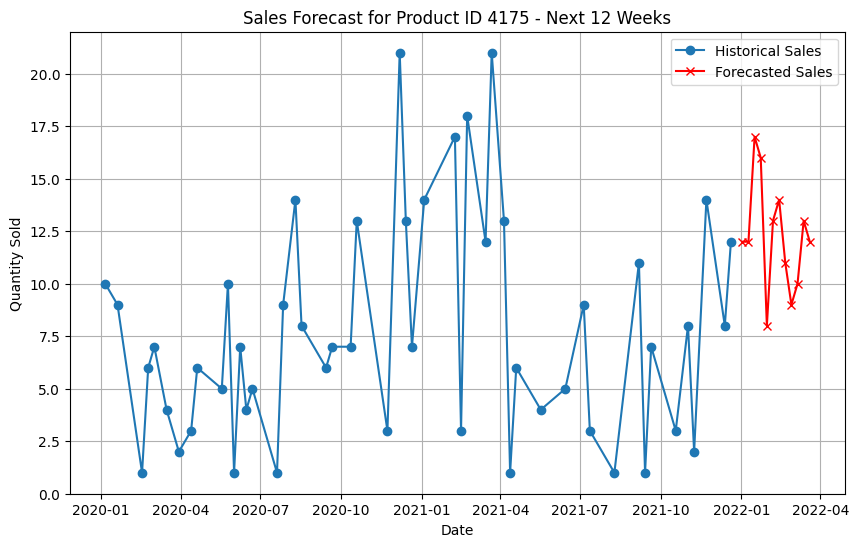

50    12.000000
51    12.000000
52    17.000002
53    16.000002
54     8.000002
55    13.000002
56    14.000002
57    11.000002
58     9.000002
59    10.000002
60    13.000002
61    12.000002
Name: predicted_mean, dtype: float64

In [48]:
plot_sales_forecast(model_fit, df, product_id=4175)

In [9]:
import joblib  # Or use import pickle


In [10]:
# Save the trained SARIMAX model
def save_model(model_fit, filename):
    joblib.dump(model_fit, filename)  # Using joblib to save the model
    # Alternatively, you can use pickle:
    # with open(filename, 'wb') as f:
    #     pickle.dump(model_fit, f)
    print(f"Model saved as {filename}")


In [ ]:
# Cell 6: Train SARIMAX model with saving functionality
def train_sarimax_model(df, product_id, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52), forecast_steps=12, save_model_filename=None):
    df_product = df[df['product_id'] == product_id]

    if df_product.empty:
        raise ValueError(f"No data found for product ID {product_id}")

    # Feature engineering and preprocessing
    df_product = feature_engineering_and_preprocessing(df_product)

    # Aggregate the sales data to weekly sales
    weekly_sales, exogenous_weekly = aggregate_weekly_sales(df_product)

    # Check if we have data to train the model
    if len(weekly_sales) == 0 or len(exogenous_weekly) == 0:
        raise ValueError(f"No valid sales or exogenous data available for product ID {product_id}")

    # Train the SARIMAX model
    model = SARIMAX(weekly_sales, exog=exogenous_weekly, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()

    # Save the trained model if a filename is provided
    if save_model_filename:
        save_model(model_fit, save_model_filename)

    # Forecasting the next 12 weeks
    forecast = model_fit.forecast(steps=forecast_steps, exog=exogenous_weekly[-forecast_steps:])

    # Plotting the historical sales and the forecasted sales
    plt.figure(figsize=(10, 6))
    
    # Plot historical sales
    plt.plot(weekly_sales.index, weekly_sales, label='Historical Sales', marker='o')
    
    # Generate the forecasted dates
    forecast_dates = pd.date_range(weekly_sales.index[-1], periods=forecast_steps + 1, freq='W')[1:]
    
    # Plot forecasted sales
    plt.plot(forecast_dates, forecast, color='red', label='Forecasted Sales', marker='x')
    
    # Add titles and labels
    plt.title(f'Sales Forecast for Product ID {product_id} - Next {forecast_steps} Weeks')
    plt.xlabel('Date')
    plt.ylabel('Quantity Sold')
    plt.legend()
    plt.grid()
    plt.show()

    return forecast


In [ ]:
# Cell 7: Train and forecast for a specific product ID and save the model
product_id = 4175
save_filename = 'sarimax_model_product_4175.pkl'  # File name for saving the model
print(f"Training model for Product ID: {product_id}")
try:
    forecast = train_sarimax_model(df, product_id, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52), forecast_steps=12, save_model_filename=save_filename)
    print(f"Forecast for Product ID {product_id}: {forecast.values}\n")
except Exception as e:
    print(f"An error occurred for Product ID {product_id}: {e}\n")


In [ ]:
# Load the saved SARIMAX model
def load_model(filename):
    return joblib.load(filename)  # Alternatively, use pickle
    # with open(filename, 'rb') as f:
    #     return pickle.load(f)

# Example: Load the model and use it for forecasting
loaded_model = load_model('sarimax_model_product_4175.pkl')
forecast = loaded_model.forecast(steps=12)
print(f"Forecast using the loaded model: {forecast}")
